# Tutorial notebook 6: Cell Type Annotation with C2S Foundation Model

In this tutorial notebook, we demonstrate how to do cell type prediction on single-cell datasets using C2S models without having to finetune your own C2S model. We will do this by utilizing the C2S-Pythia-410M cell type prediction foundation model, which is a pretrained C2S model which was trained to do cell type prediction across many datasets. We will examine annotating cells in our dataset through the lens of this cell type annotation C2S model.

This notebook will:
1. Load an immune tissue single-cell dataset from Domínguez Conde et al. (preprocessed in tutorial notebook 0, two sample donors)
    - Citation: Domínguez Conde, C., et al. "Cross-tissue immune cell analysis reveals tissue-specific features in humans." Science 376.6594 (2022): eabl5197.
2. Load a C2S model which was pretrained to do cell type annotation on many datasets
3. Annotate a subset of cells in the single-cell dataset using the C2S model

Let's get started!

We will begin by importing the necessary libraries. These include Python's built-in libraries, third-party libraries for handling numerical computations, progress tracking, and specific libraries for single-cell RNA sequencing data and C2S operations.

In [27]:
# Python built-in libraries
import os
import pickle
import random
from collections import Counter

# Third-party libraries
import numpy as np
from tqdm import tqdm

# Single-cell libraries
import anndata
import scanpy as sc

# Cell2Sentence imports
import cell2sentence as cs
from cell2sentence.tasks import predict_cell_types_of_data

In [28]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)

# Load Data

Next, we will load the preprocessed dataset from the tutorial 0. This dataset has already been filtered and normalized, so it it ready for transformation into cell sentences.

<font color='red'>Please make sure you have completed the preprocessing steps in Tutorial 0 before running the following code, if you are using your own dataset.</font>. Ensure that the file path is correctly set in <font color='gold'>DATA_PATH</font> to where your preprocessed data was saved from tutorial 0.

In [29]:
DATA_PATH = "/data/Mamba/Project/Single_Cell/Benchmark/Cell2Setence/Data/A013_processed_sampled_w_cell2sentence.h5ad"

In [30]:
adata = anndata.read_h5ad(DATA_PATH)
adata

AnnData object with n_obs × n_vars = 1000 × 14496
    obs: 'donor_id', 'batch', 'sex', 'age', 'disease', 'cell_type', 'main_celltype', 'tissue', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'organism'
    var: 'gene_name', 'ensembl_id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'cell_type_colors', 'disease_colors', 'log1p', 'neighbors', 'pca', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [31]:
adata.obs = adata.obs[["cell_type", "disease", "tissue", "organism"]]

In [32]:
adata.obs.head()

,cell_type,disease,tissue,organism
1637,naive B cell,normal,blood,blood
3978,memory B cell,normal,blood,blood
8448,naive B cell,normal,blood,blood
11387,naive B cell,normal,blood,blood
11468,naive B cell,normal,blood,blood


In [33]:
adata.var.head()

,gene_name,ensembl_id,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
AL627309.1,AL627309.1,ENSG00000238009,3,False,3,0.004116,99.7,4.115806
AL627309.5,AL627309.5,ENSG00000241860,10,False,10,0.014258,99.0,14.258169
LINC01409,LINC01409,ENSG00000237491,13,False,13,0.018464,98.7,18.464311
LINC01128,LINC01128,ENSG00000228794,25,False,25,0.037282,97.5,37.282384
LINC00115,LINC00115,ENSG00000225880,8,False,8,0.011289,99.2,11.289066


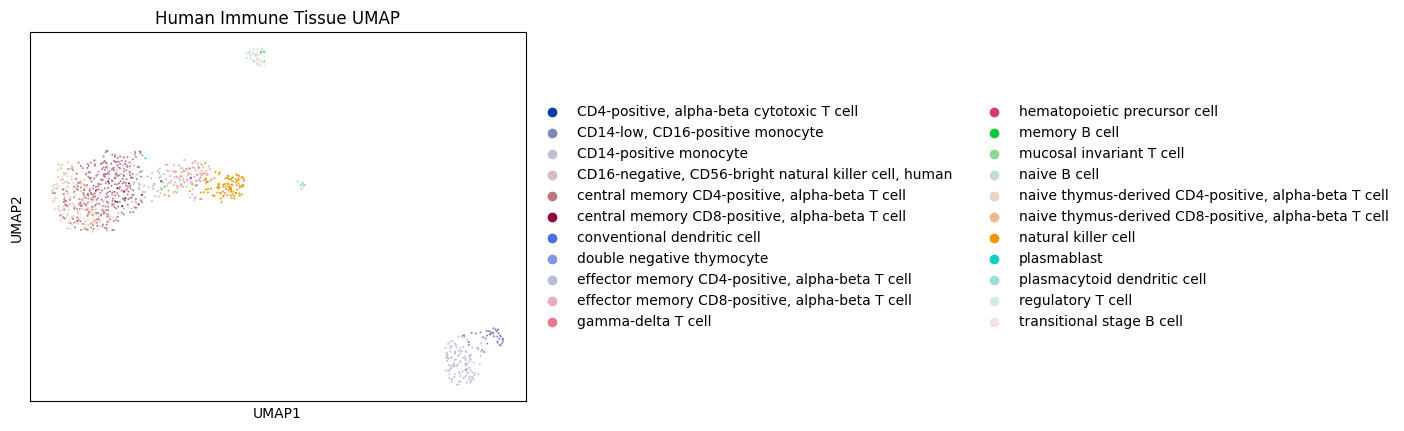

In [34]:
sc.pl.umap(
    adata,
    color="cell_type",
    size=8,
    title="Human Immune Tissue UMAP",
)

In [35]:
adata.X.max()

np.float64(1.000156046988993)

We are expecting log10 base 10 transformed data, with a maximum value somewhere around 3 or 4. Make sure to start with processed and normalized data when doing the cell sentence conversion!

# Cell2Sentence Conversion

In this section, we will transform our AnnData object containing our single-cell dataset into a Cell2Sentence (C2S) dataset by calling the functions of the CSData class in the C2S code base. Full documentation for the functions of the CSData class can be found in the documentation page of C2S.

In [36]:
adata_obs_cols_to_keep = adata.obs.columns.tolist()
adata_obs_cols_to_keep

['cell_type', 'disease', 'tissue', 'organism']

In [37]:
# Create CSData object
arrow_ds, vocabulary = cs.CSData.adata_to_arrow(
    adata=adata, 
    random_state=SEED, 
    sentence_delimiter=' ',
    label_col_names=adata_obs_cols_to_keep
)

WARN: more variables (14496) than observations (1000)... did you mean to transpose the object (e.g. adata.T)?
WARN: more variables (14496) than observations (1000), did you mean to transpose the object (e.g. adata.T)?
  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1628.48it/s]


In [38]:
arrow_ds

Dataset({
    features: ['cell_name', 'cell_sentence', 'cell_type', 'disease', 'tissue', 'organism'],
    num_rows: 1000
})

In [39]:
sample_idx = 0
arrow_ds[sample_idx]

{'cell_name': '1637',
 'cell_sentence': 'MALAT1 CD74 EEF1A1 RPS12 RPLP1 RPL19 MT-CO2 RPS27 RPS28 RPL13 RPL10 RPL28 RPL18A RPL32 RPL30 RPL39 RPL34 RPL37 RPS25 RPS7 RPS15A HLA-DRA RPS18 B2M RPL11 RPL29 RPS27A FAU RPL12 RPS23 RPS13 RPS15 RPS8 RPS6 RPS5 PTMA MT-CO3 RPL36 MT-ATP6 RPL18 MT-CO1 RPS3 RPL14 RPL8 MT-CYB RPS21 RPL10A RPL22 RPS24 RPL7A RPL24 TPT1 RPLP0 RPL26 RPL35A TMSB10 TMSB4X COX4I1 RPL21 RPSA RPS3A RPS2 FTH1 CD37 RACK1 RPS19 MT-ND1 UBC RPL23A EEF1G HLA-B RPS4X RPL35 RPL17 IGHM H3F3B UBA52 CD52 ACTB MT-ND3 PPIA MT-ND4L CIRBP OST4 RPL9 LAPTM5 HLA-DRB1 PPDPF EIF1 HLA-DPA1 RPS16 HMGB1 RPL3 RPL27 EEF1D RPS14 MBNL1 MT-ND5 RPS4Y1 HLA-DRB5 PFDN5 FTL MIF LSP1 MT-ND4 SRSF7 APRT TXNIP ATL2 SH3BGRL3 MT-ND2 HINT1 SYF2 EIF3F EMP3 HLA-A PIAS1 JUND SSU72 CYBA RPS9 EIF5B RPL41 RPS11 THOC2 RPL6 SMAP2 MAT2B UBB MT-ND6 SF1 PFN1 USP16 NPM1 ACTG1 MT-ATP8 TBRG1 NDUFB11 NAPA TPM3 SARAF HLA-DQB1 ANKRD44 ATP5MC2 CALCOCO2 SMDT1 LIMD2 CXCR4 RPL7 RPL4 CBX3 MS4A1 RPL36A IP6K2 RPLP2 EEF2 NDUFA2 PRPF38B RPL1

This time, we will leave off creating our CSData object until after we load our C2S model. This is because along with the model checkpoint, we saved the indices of train, val, and test set cells, which will allow us to select out test set cells for inference.

# Load C2S Model

Now, we will load a C2S model with which we will do cell type annotation. For this tutorial, this model will be the C2S-Pythia-410M cell type prediction foundation model, which has already been trained to do cell type annotation on a diverse set of single-cell datasets from CellxGene and Human Cell Atlas. More details about this model can be found in the Model Zoo section of the GitHub ReadME, or in the Huggingface page of the C2S-Pythia model.

We can define our CSModel object with our pretrained cell type prediction model as follows:

In [40]:
# Define CSModel object
cell_type_prediction_model_path = "/data/Mamba/Data/hf_cache/hub/models--vandijklab--C2S-Pythia-410m-cell-type-prediction/snapshots/5a4dc3b949b5868ca63752b37bc22e3b0216e435"
save_dir = "./"
save_name = "cell_type_pred_pythia_410M_inference"
csmodel = cs.CSModel(
    model_name_or_path=cell_type_prediction_model_path,
    save_dir=save_dir,
    save_name=save_name
)

Using device: cuda


In [41]:
arrow_ds

Dataset({
    features: ['cell_name', 'cell_sentence', 'cell_type', 'disease', 'tissue', 'organism'],
    num_rows: 1000
})

For this tutorial, we will select a subset of 100 cells to annotate from our dataset

In [42]:
arrow_ds

Dataset({
    features: ['cell_name', 'cell_sentence', 'cell_type', 'disease', 'tissue', 'organism'],
    num_rows: 1000
})

Now, we create our CSData object using this subset of cells which we want to annotate:

In [43]:
c2s_save_dir = "/home/scbjtfy/cell2sentence/tutorials/cell_type_pred_pythia_410M_inference"  # C2S dataset will be saved into this directory
c2s_save_name = "cell_annotation_with_foundation_model"  # This will be the name of our C2S dataset on disk

In [44]:
csdata = cs.CSData.csdata_from_arrow(
    arrow_dataset=arrow_ds, 
    vocabulary=vocabulary,
    save_dir=c2s_save_dir,
    save_name=c2s_save_name,
    dataset_backend="arrow"
)

Saving the dataset (0/1 shards):   0%|          | 0/1000 [00:00<?, ? examples/s]

In [45]:
print(csdata)

CSData Object; Path=/home/scbjtfy/cell2sentence/tutorials/cell_type_pred_pythia_410M_inference/cell_annotation_with_foundation_model, Format=arrow


# Predict cell types

Now that we have loaded our finetuned cell type prediction model and have our small set of cells to annotate, we will do cell type prediction inference using our C2S model. We can use the function predict_cell_types_of_data() from the tasks.py, which will take a CSModel() object and apply it to do cell type prediction on a CSData() object.

In [46]:
predicted_cell_types = predict_cell_types_of_data(
    csdata=csdata,
    csmodel=csmodel,
    n_genes=200
)

Reloading model from path on disk: ./cell_type_pred_pythia_410M_inference
Predicting cell types for 1000 cells using CSModel...


100%|██████████| 1000/1000 [10:11<00:00,  1.64it/s]


In [47]:
len(predicted_cell_types)

1000

In [48]:
predicted_cell_types[:3]

['naive B cell.', 'B cell.', 'naive B cell.']

In [49]:
arrow_ds

Dataset({
    features: ['cell_name', 'cell_sentence', 'cell_type', 'disease', 'tissue', 'organism'],
    num_rows: 1000
})

Now, we can see what labels our C2S model has predicted for these cells.

In [50]:
for model_pred, gt_label in zip(predicted_cell_types[::5], arrow_ds["cell_type"][::5]):
    # C2S might predict a period at the end of the cell type, which we remove
    if model_pred[-1] == ".":
        model_pred = model_pred[:-1]
    
    print("Predicted label: {}\nGround truth label: {}\n".format(model_pred, gt_label))

Predicted label: naive B cell
Ground truth label: naive B cell

Predicted label: naive B cell
Ground truth label: transitional stage B cell

Predicted label: naive B cell
Ground truth label: naive B cell

Predicted label: naive B cell
Ground truth label: naive B cell

Predicted label: naive B cell
Ground truth label: naive B cell

Predicted label: naive B cell
Ground truth label: transitional stage B cell

Predicted label: naive B cell
Ground truth label: naive B cell

Predicted label: B cell
Ground truth label: transitional stage B cell

Predicted label: malignant cell
Ground truth label: transitional stage B cell

Predicted label: CD4-positive, alpha-beta T cell
Ground truth label: central memory CD4-positive, alpha-beta T cell

Predicted label: CD4-positive, alpha-beta T cell
Ground truth label: regulatory T cell

Predicted label: CD4-positive, alpha-beta T cell
Ground truth label: central memory CD4-positive, alpha-beta T cell

Predicted label: CD4-positive, alpha-beta T cell
Groun

In [51]:
len(predicted_cell_types)

1000

In [52]:
import pandas as pd

# 假设你的变量如下：
# predicted_cell_types = [...]
# arrow_ds["cell_type"] = [...]

# 创建列表保存结果
results = []

for model_pred, gt_label in zip(predicted_cell_types, arrow_ds["cell_type"]):
    # 去掉末尾句号
    if model_pred.endswith("."):
        model_pred = model_pred[:-1]
    
    # 保存到列表
    results.append({"Predicted": model_pred, "GroundTruth": gt_label})

# 转成 DataFrame
df = pd.DataFrame(results)

# 保存为 CSV 文件
output_path = "c2s_A013_predict.csv"
df.to_csv(output_path, index=False, encoding="utf-8-sig")

print(f"\n✅ 已保存到: {output_path}")
print(f"共保存 {len(df)} 条记录。")



✅ 已保存到: c2s_A013_predict.csv
共保存 1000 条记录。


We can see that our C2S model makes accurate predictions at the cell type, however because of slight differences in cell type annotations, C2S sometimes does not get the correct cell type label. This is still useful, however, because this annotation ability of C2S can be used on new datasets with unknown cells to examine groups of cells. Because C2S can flexibly predict cell type annotations in natural language, we can annotate new cells using C2S as a quick way of checking and exploring clusters of cells in new or unknown data!